In [15]:
import db
import networkx as nx
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt

In [16]:
import os
os.environ["JAVA_HOME"] = "/opt/homebrew/opt/openjdk@11/"

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/local/opt/openjdk@11/"

In [17]:
from pyspark import *
from pyspark.sql import *
from graphframes import *
import findspark

findspark.init("./spark-3.2.0-bin-hadoop3.2")

# Start a Spark session
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [18]:
connection = db.connect()
cursor = connection.cursor()

In [19]:
cursor.execute("""
    SELECT d1.officer_id src, d2.officer_id dst, COUNT(*) shifts_worked
    FROM data_officerassignmentattendance d1
        JOIN data_officerassignmentattendance d2 
        ON d1.start_timestamp = d2.start_timestamp 
            AND d1.beat_id = d2.beat_id 
            AND d1.officer_id < d2.officer_id
    WHERE d1.present_for_duty AND d2.present_for_duty
    GROUP BY d1.officer_id, d2.officer_id;
""")
tsedges = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])

In [20]:
tsedges

,src,dst,shifts_worked
0,1,157,2
1,1,916,6
2,1,997,1
3,1,1199,2
4,1,1548,1
...,...,...,...
432744,35546,35548,30
432745,35546,35550,29
432746,35547,35548,25
432747,35547,35550,26


In [21]:
cursor.execute("""
    SELECT t1.officer_id src, t2.officer_id dst, COUNT(DISTINCT t1.event_id)
    FROM trr_trr t1 JOIN trr_trr t2 ON t1.event_id = t2.event_id AND t1.officer_id < t2.officer_id
    GROUP BY t1.officer_id, t2.officer_id
    ORDER BY count(DISTINCT t1.event_id) DESC;
""")
edges = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])

In [22]:
edges

,src,dst,count
0,31795,32105,24
1,2798,31576,20
2,17634,29992,18
3,1444,29209,16
4,27669,29670,16
...,...,...,...
29382,1927,16115,1
29383,1927,16265,1
29384,1927,21210,1
29385,1927,23774,1


In [23]:
edges_reverse = edges.copy(deep=True)
edges_reverse['tmp'] = edges_reverse['src']
edges_reverse['src'] = edges_reverse['dst']
edges_reverse['dst'] = edges_reverse['tmp']
edges_reverse = edges_reverse.drop(columns=['tmp'])
edges_reverse

,src,dst,count
0,32105,31795,24
1,31576,2798,20
2,29992,17634,18
3,29209,1444,16
4,29670,27669,16
...,...,...,...
29382,16115,1927,1
29383,16265,1927,1
29384,21210,1927,1
29385,23774,1927,1


In [24]:
aedges = pd.concat([edges, edges_reverse])
aedges

,src,dst,count
0,31795,32105,24
1,2798,31576,20
2,17634,29992,18
3,1444,29209,16
4,27669,29670,16
...,...,...,...
29382,16115,1927,1
29383,16265,1927,1
29384,21210,1927,1
29385,23774,1927,1


In [25]:
cursor.execute("""
    SELECT  id, first_name || ' ' || last_name "name", trr_count
    FROM data_officer
    WHERE id IN (SELECT DISTINCT  officer_id FROM trr_trr);
""")
nodes = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])

In [26]:
nodes

,id,name,trr_count
0,32312,Randall Ryan,4
1,32358,Kevin Stoll,5
2,32461,Albert Krueger,1
3,15636,Marie Lane,1
4,31793,Adam Aleszczyk,4
...,...,...,...
10793,32398,Thomas Waldera,1
10794,32098,Christoph Kennedy,2
10795,25503,Christ Savickas,7
10796,25732,Andrew Schoeff,1


In [133]:
pr = GraphFrame(
    spark.createDataFrame(nodes),
    spark.createDataFrame(aedges),
).pageRank(resetProbability=0.15, tol=0.01)
pr.vertices.orderBy('pagerank', ascending=False).show()

+-----+-------------------+---------+-----------------+
|   id|               name|trr_count|         pagerank|
+-----+-------------------+---------+-----------------+
|10583|     George Granias|       72|8.032597730059983|
|21371|    Phillip Orlando|       41|7.571730383938765|
|32118|         Cesar Kuri|       65|6.822480218925139|
|14400|      Patrick Kelly|       62|6.303867803567349|
|28970|       Jeff Truhlar|       37|6.112292803559247|
|30091|   Takia Washington|       46|5.420885015731482|
|31030|         Lucas Wise|       53|5.386760743493899|
|14969|Daniel Kolodziejski|       53|5.113931457720295|
|32402|      Michael Walsh|       48|5.079307486222686|
| 8176|       Elmer Fabian|       44|5.060543269866183|
|12299|  Evangelos Hitiris|       41|5.046922077503595|
|13605|       Mark Johnson|       46|5.003785026688874|
|29670|     Adrian Vivanco|       64|4.994835741261612|
|13778|         Cory Jones|       45|4.977045443174628|
|20154|         Kevin Muth|       23|4.950292272

In [138]:
pagerank = pr.vertices.toPandas().sort_values('pagerank', ascending=False)
pagerank

,id,name,trr_count,pagerank
10419,10583,George Granias,72,8.032598
4876,21371,Phillip Orlando,41,7.571730
8791,32118,Cesar Kuri,65,6.822480
415,14400,Patrick Kelly,62,6.303868
3544,28970,Jeff Truhlar,37,6.112293
...,...,...,...,...
6572,4460,Terri Chavez,2,0.181905
510,23320,Michael Rafferty,1,0.181905
1179,12752,Fred Hughes,1,0.181905
6568,300,Jennifer Aldridge,1,0.181905


In [140]:
pagerank[:1000].to_csv('pagerank.csv', index=False)

In [27]:
triangles = GraphFrame(
    spark.createDataFrame(nodes),
    spark.createDataFrame(edges),
).triangleCount().toPandas()
triangles = triangles.sort_values(by=['count'], ascending=False)

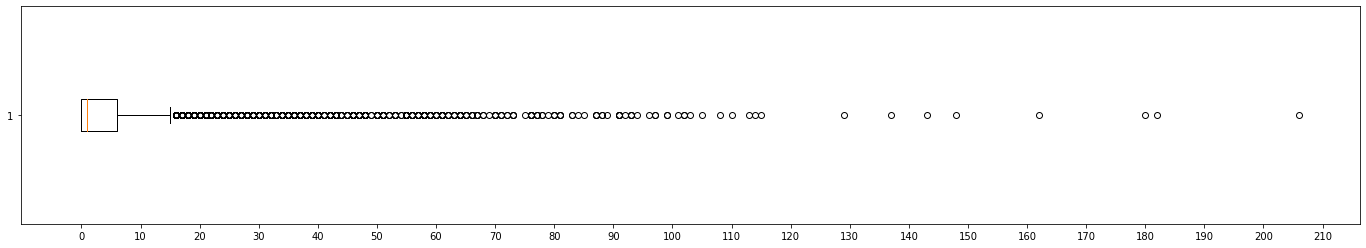

In [277]:
plt.figure(figsize=(24,4))
plt.boxplot(triangles['count'], vert=False)
plt.xticks(range(0,220,10))
plt.show()

In [213]:
triangle_ids = set(triangles[:100]['id'])
len(triangle_ids)

100

In [126]:
gfull = nx.from_pandas_edgelist(aedges, 'src', 'dst')

In [280]:
nx.average_clustering(gfull)

0.29707584853607866

In [127]:
gclustering = dict(sorted(nx.clustering(gfull).items(), key=lambda x: x[1], reverse=True))

In [286]:
gclustering[10583]

0.06128364389233954

In [128]:
gtriangles = dict(sorted(nx.triangles(gfull).items(), key=lambda x: x[1], reverse=True))

In [287]:
gtriangles[10583]

148

In [30]:
triangles[:100]

,count,id,name,trr_count
10154,206,21371,Phillip Orlando,41
6969,182,13313,Steve Jarosz,20
6046,180,11615,Ryan Harty,22
6426,162,30561,Wayne Wiberg,30
10370,148,10583,George Granias,72
...,...,...,...,...
10364,63,5645,Daniel Cravens,38
8372,63,19866,Michael Mulcahy,12
3784,63,18872,Dominic Merola,26
8146,62,27084,Fernando Soto,12


In [129]:
interested = set(triangles[:150]['id'])

In [71]:
def plot_graph(edges):
    plt.figure(figsize=(30,20))
    g = nx.Graph()
    g = nx.from_pandas_edgelist(edges, 'src', 'dst')
    nx.draw(g, with_labels=False, arrows=False, node_color='grey', node_size=50)
    plt.show()

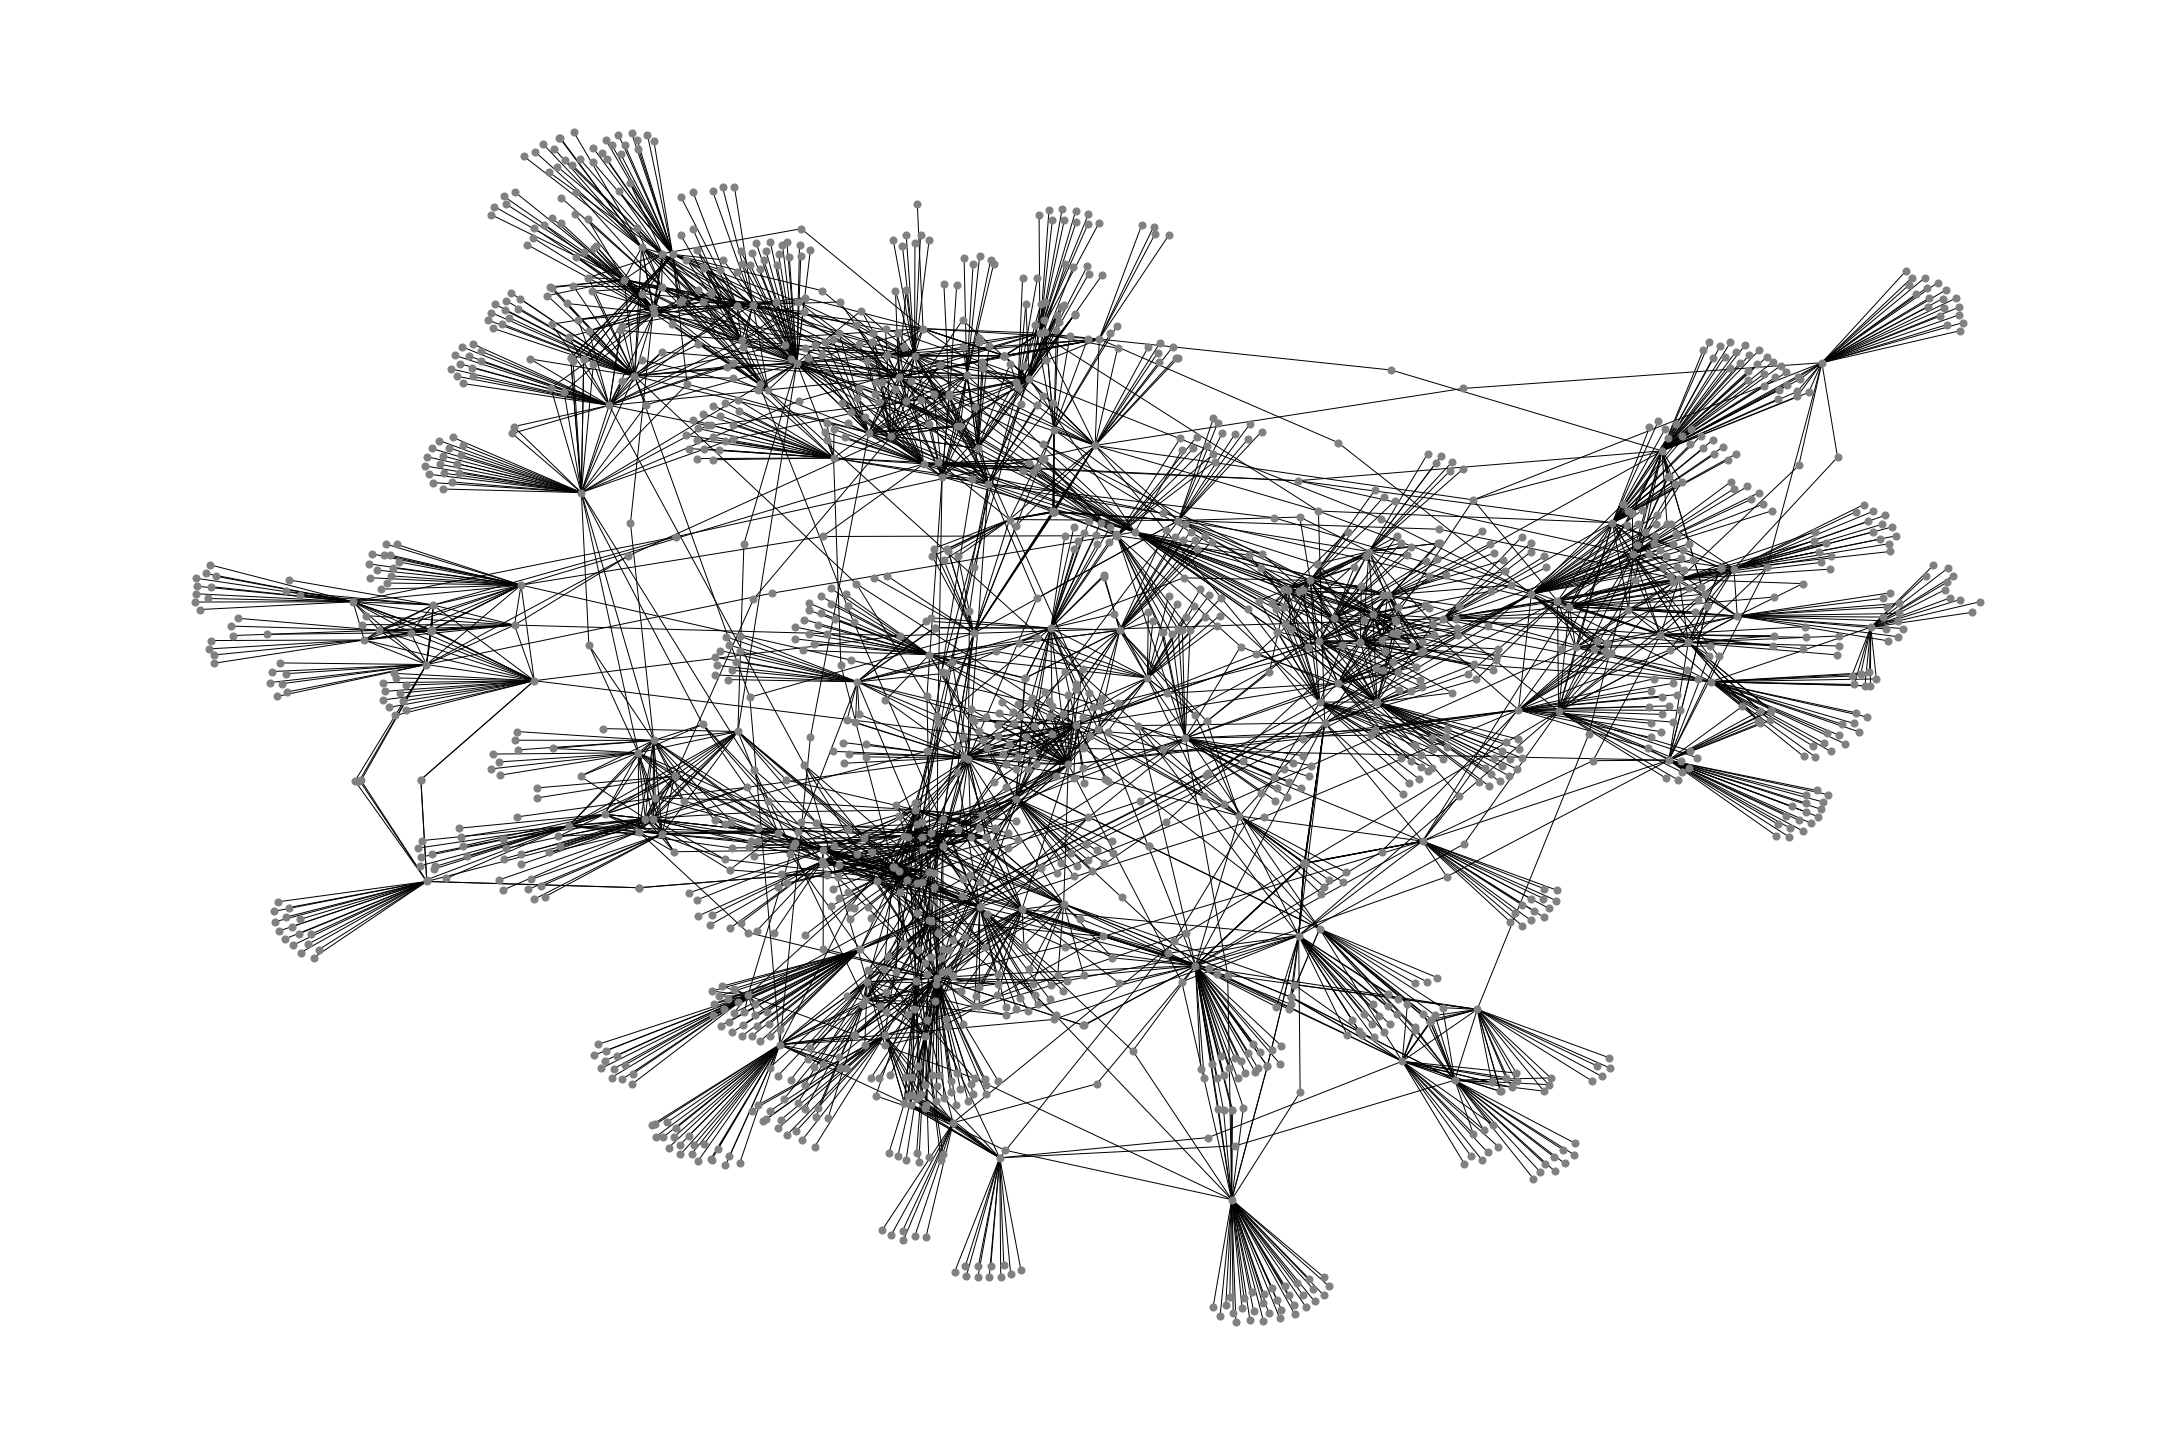

In [130]:
plot_graph(edges[(edges['src'].isin(interested)) | (edges['dst'].isin(interested))])

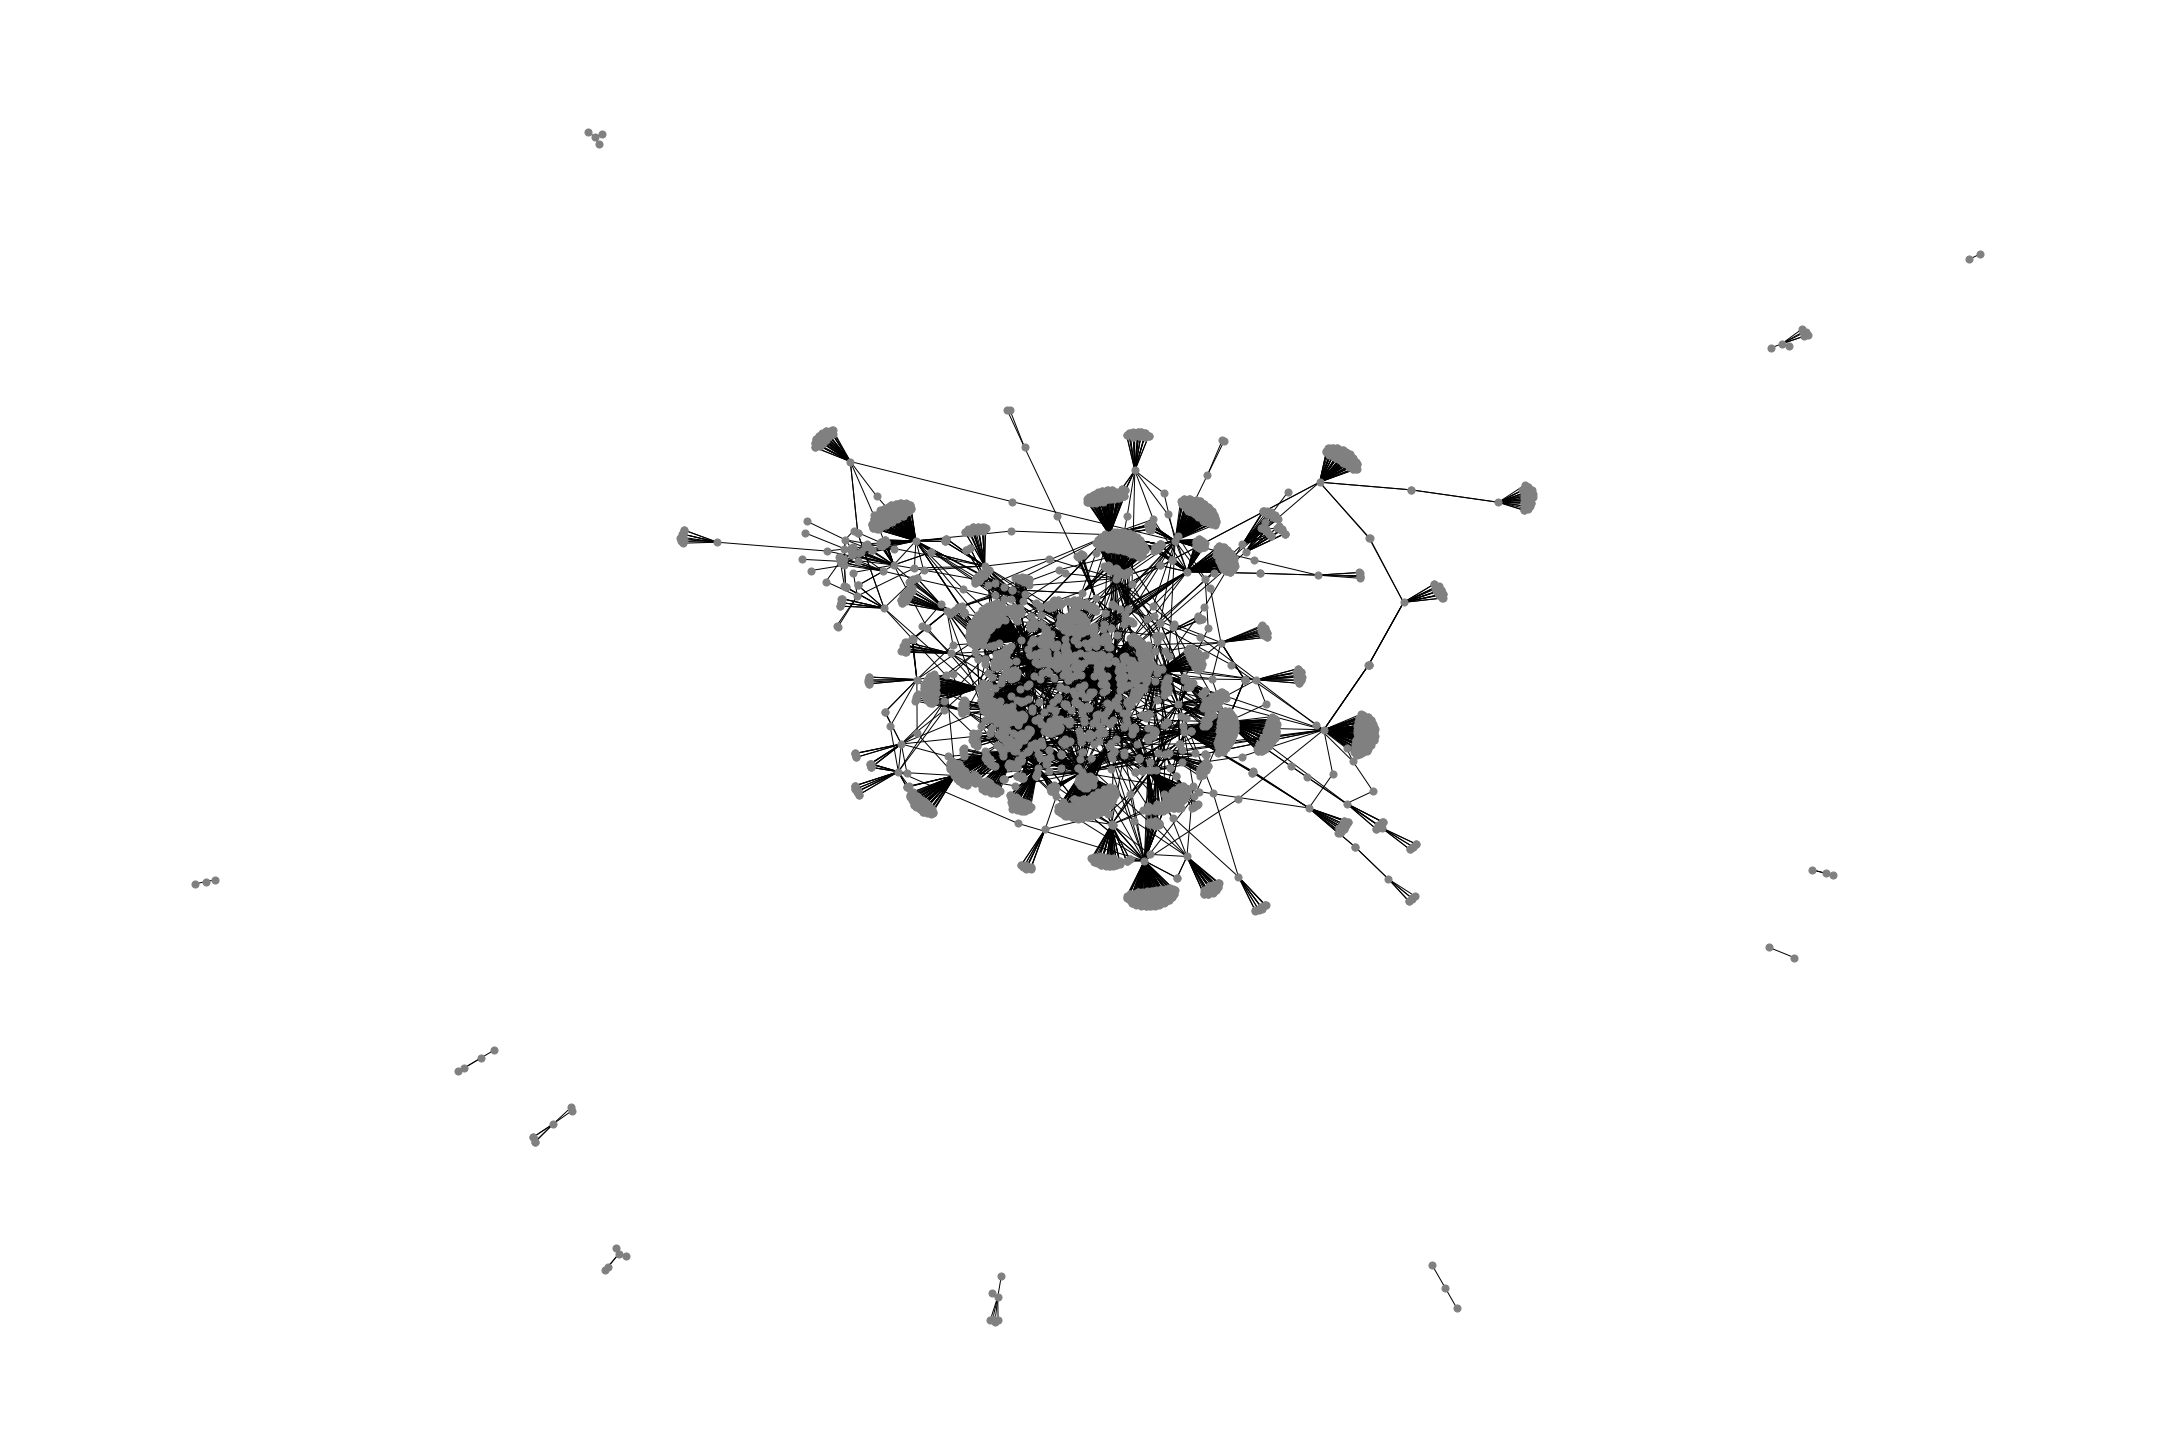

In [131]:
plot_graph(tsedges[(tsedges['src'].isin(interested)) | (tsedges['dst'].isin(interested))])

In [77]:
base_triangles = GraphFrame(
    spark.createDataFrame(nodes),
    spark.createDataFrame(tsedges),
).triangleCount().toPandas()
base_triangles = base_triangles.sort_values(by=['count'], ascending=False)

In [93]:
base_triangles

,count,id,name,trr_count
7862,2514,19903,Kevin Mulligan,4
3742,2425,3568,Joseph Cabrera,4
3130,2387,16553,Rodrigo Lopez,5
4923,2065,18703,Joshua Medina,1
6726,2047,2140,Anthony Blanco,7
...,...,...,...,...
3730,0,29247,Ross Valenti,4
3726,0,28227,Delroy Taylor,4
3724,0,32200,Angelo Monaco,11
3721,0,20169,Patrick Myers,3


In [94]:
triangles

,count,id,name,trr_count
10154,206,21371,Phillip Orlando,41
6969,182,13313,Steve Jarosz,20
6046,180,11615,Ryan Harty,22
6426,162,30561,Wayne Wiberg,30
10370,148,10583,George Granias,72
...,...,...,...,...
3559,0,2093,Darrion Blackburn,5
3556,0,6006,Jonathan Cwynar,3
3555,0,22835,Joseph Porebski,1
3551,0,30884,James Williamson,1


In [113]:
triangles['diff'] = (triangles[['count']].sub(
    base_triangles[['count']], axis='columns'
)).sort_values('count', ascending=False)

In [116]:
triangles.sort_values('diff', ascending=False)[:50]

,count,id,name,trr_count,diff
10154,206,21371,Phillip Orlando,41,206
6426,162,30561,Wayne Wiberg,30,162
514,143,32118,Cesar Kuri,65,143
6969,182,13313,Steve Jarosz,20,139
2995,137,31337,James Wynn,19,137
6046,180,11615,Ryan Harty,22,122
8043,115,8374,Joseph Ferenzi,10,115
9772,113,20154,Kevin Muth,23,113
7153,103,8138,Glenn Evans,21,103
6568,102,20860,Mark O Connor,6,102


In [121]:
triangles.sort_values('diff', ascending=False)[:200].to_csv('triangles.csv', index=False)